In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm, trange

In [2]:
data = pd.read_csv(r"D:\Productivity\Projects\RiskFieldImitation-main\data\ngsim\i80 sample.csv")

In [11]:
def reformat_ngsim(data, metric=True, record=-1):
    _unit_coef = 0.3048 if metric else 1

    _id = data.Vehicle_ID.values 
    _frame = data.Frame_ID.values 
    _x = data.Local_Y.values * _unit_coef
    _y = data.Local_X.values * _unit_coef
    _len = data.v_Length.values * _unit_coef
    _wid = data.v_Width.values * _unit_coef
    _record = np.repeat(record, len(data))
    _dir = np.repeat(1, len(data))

    dt = 0.1
    dx = data.groupby('Vehicle_ID')['Local_Y'].diff()
    dy = data.groupby('Vehicle_ID')['Local_X'].diff()

    _vx = dx/dt * _unit_coef
    _vy = dy/dt * _unit_coef
    _ax = _vx.diff()/dt 
    _ay = _vy.diff()/dt 


    df = pd.DataFrame(
        {
            'id':_id,
            'frame':_frame,
            'record':_record,
            'x':_x-_len/2,
            'y':_y,
            'xVelocity':_vx,
            'yVelocity':_vy,
            'xAcceleration':_ax,
            'yAcceleration':_ay,
            'length':_len,
            'width':_wid,
            'direction':_dir,
        }
    )
    df = df.sort_values(by=['id','frame'])
    return df







In [12]:
_data = reformat_ngsim(data)

In [13]:
_data.xVelocity

0                NaN
1          14.020800
2          13.719048
3          13.716000
4          13.828776
             ...    
1048570     3.051048
1048571     3.041904
1048572     3.060192
1048573     3.096768
1048574     3.066288
Name: xVelocity, Length: 1048575, dtype: float64

In [14]:
_data.xAcceleration

0              NaN
1              NaN
2         -3.01752
3         -0.03048
4          1.12776
            ...   
1048570    0.03048
1048571   -0.09144
1048572    0.18288
1048573    0.36576
1048574   -0.30480
Name: xAcceleration, Length: 1048575, dtype: float64

In [6]:
def get_interaction_vehicle_indices(tensor, max_dist=50, grid_dist=1000):
    """
    Finds nearby vehicle IDs within a distance threshold using a grid-based approach.
    Returns a tensor of shape (N, M), where N = input size and M = max neighbors (padded with 0).
    
    Args:
        tensor (torch.Tensor): Shape (N, 4) where:
            - Column 0: Frame number
            - Column 1: Vehicle ID
            - Column 2: X coordinate
            - Column 3: Y coordinate
        distance_threshold (float): Distance threshold to consider as "nearby".
        max_neighbors (int): Maximum number of neighbors to keep per vehicle (padded with 0).

    Returns:
        torch.Tensor: Shape (N, M), where each row contains up to `M` nearest vehicle IDs.
    """
    frames = tensor[:, 0]  # Extract frame column
    positions = tensor[:, 2:4]  # Extract x, y coordinates
    vids = tensor[:, 1]
    lengths = tensor[:, -3]
    widths = tensor[:, -2]
    directions = tensor[:, -1]
    indices = torch.arange(tensor.shape[0], device=tensor.device)  # Create an index for vehicle IDs
    
    allow_reverse = True
     # **Step 1: Assign grid IDs (divide x-coordinates by 50m)**
    grid_x = (positions[:, 0] // grid_dist).int()  # Grid ID based on x position

    unique_grid = torch.sort(torch.unique(grid_x))[0]

    keys = []
    neighbors = []

    for grid in tqdm(unique_grid):
        neighbor_grid_mask = (grid_x - grid ==1) | (grid_x == grid)

        neighbor_grid_positions = positions[neighbor_grid_mask]
        neighbor_grid_frames = frames[neighbor_grid_mask]
        neighbor_grid_indices = indices[neighbor_grid_mask]
        neighbor_grid_directions = directions[neighbor_grid_mask]
        neighbor_lengths = lengths[neighbor_grid_mask]
        neighbor_widths = widths[neighbor_grid_mask]

        _neighbor_grid_position_x = torch.abs(neighbor_grid_positions[:,0].unsqueeze(1) - neighbor_grid_positions[:,0].unsqueeze(0)) - 0.5*(neighbor_lengths.unsqueeze(1)+neighbor_lengths.unsqueeze(0))
        
        
        neighbor_grid_position_x = torch.clamp(_neighbor_grid_position_x, min=0)
        neighbor_dist_mask = neighbor_grid_position_x < max_dist

        # neighbor_dist_mask = (torch.norm(neighbor_grid_positions.unsqueeze(1) - neighbor_grid_positions.unsqueeze(0), dim=2) < max_dist) 
        frame_mask = neighbor_grid_frames.unsqueeze(1) == neighbor_grid_frames.unsqueeze(0)
        direction_mask = neighbor_grid_directions.unsqueeze(1) == neighbor_grid_directions.unsqueeze(0)
        neighbor_mask = neighbor_dist_mask & frame_mask & direction_mask
        n_shape = neighbor_mask.shape[0]
        neighbor_mask[range(n_shape), range(n_shape)] = 0
        
        idx_x, idx_y = torch.where(neighbor_mask)

        keys.append (neighbor_grid_indices[idx_x])
        neighbors.append (neighbor_grid_indices[idx_y])

    pairs = torch.stack((torch.cat(keys), torch.cat(neighbors)), dim=1)
    pairs = pairs if allow_reverse else torch.sort(pairs, dim=1)[0]
    unique_pairs = torch.unique(pairs, dim=0)

    return unique_pairs

In [7]:
tracks = _data[(_data.frame<=1600)&(_data.frame>=1500)]

In [8]:
pairs = get_interaction_vehicle_indices(torch.tensor(tracks.values[:,(1,0,3,4,-3,-2,1)], device='cuda'), grid_dist=50)

100%|██████████| 11/11 [00:00<00:00, 155.33it/s]


In [10]:
pairs

tensor([[    0,    16],
        [    0,    17],
        [    0,    56],
        ...,
        [15724, 15598],
        [15724, 15660],
        [15724, 15681]], device='cuda:0')

In [9]:
tracks.x

100646    495.561518
100647    495.936118
100648    496.310412
100649    496.685011
100650    497.059306
             ...    
251445     49.141075
251446     49.747627
251447     50.391365
251448     51.038760
251449     51.680364
Name: x, Length: 15725, dtype: float64

[-0.5, 3.5, 7.25, 11.0, 14.75, 18.5, 22.5]

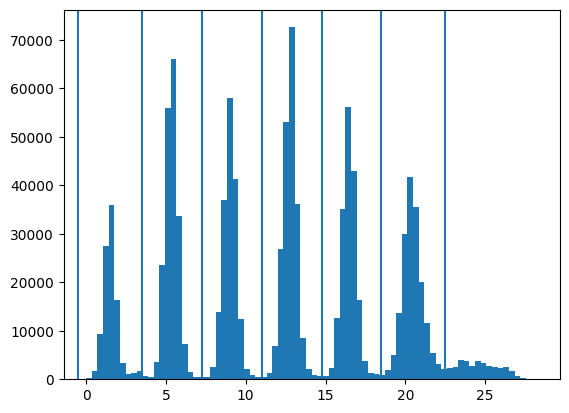

In [23]:
plt.hist(_data.y, bins=80)
lanes = [-0.5,  3.5 ,  7.25, 11.  , 14.75, 18.5 , 22.5]
_ = [ plt.axvline(l) for l in lanes ]
lanes